In [1]:
from IPython.display import display, Math, Latex
# This is imported for proper rendering of Latex in Notebook.

import numpy as np

# import for generating plots
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Polynomial Regression

This notebook will implement **Polynomial Regression** from scratch with basic python libraries like `numpy`. Recall that polynomial regression is linear regression with an additional step of polynomial transformation.

`Features ---> Polynomial Transformation ---> Linear Regression ---> Labels`

We will reuse the `LinReg` class that implements the Linear Regression model from the *W2* notebook.

We will implement:
- Polynomial Transformation Function

A few helper functions for:
- Generation of training data with non-linear relationship between features and labels. We generate examples with a single feature $x_1$ and label $y$.
- Visualization of training data and model fitment.

We use polynomial transformations of different degrees for modeling relationship between input features and labels. Each degree results in a new polynomial model. Thus, we have multiple polynomial models from which we need to select the best performing model. We have implemented the model selection scheme towards the *end* of this notebook.

### The LinReg Class

In [2]:
class LinReg(object):
    '''
    Linear Regression model
    -----------------------
    y = X@w
    X: Feature matrix
    w: Weight vector
    y: Label vector
    '''

    def __init__(self):
        self.t0 = 200
        self.t1 = 100000
    
    def predict(self, X:np.ndarray) -> np.ndarray:
        '''Prediction of output label for a given input.

        Args:
            X: Feature matrix for given inputs
        
        Returns:
            y: Output label vector as predicted by the given model
        '''

        y = X @ self.w
        
        return y
    
    def loss(self, X:np.ndarray, y:np.ndarray) -> float:
        '''Calculate loss for a model based on actual labels.

        Args:
            X: Feature matrix for given inputs
            y: Output label vector as known from the dataset (actual labels)
        
        Returns:
            Loss
        '''

        e = y - self.predict(X)

        return (1/2) * (np.transpose(e) @ e)
    
    def rmse(self, X:np.ndarray, y:np.ndarray) -> float:
        '''Calculate root mean squared error of prediction based on actual labels.

        Args:
            X: Feature matrix for given inputs
            y: Output label vector as known from the dataset (actual label)
        
        Returns:
            RMSE
        '''
        return np.sqrt((2/X.shape[0]) * self.loss(X,y))
    
    # Normal Equation based estimation
    def fit(self, X:np.ndarray, y:np.ndarray) -> np.ndarray:
        '''Estimate parameters of linear regression model with normal equation.

        Args:
            X: Feature matrix for given inputs
            y: Output label vector as known from the dataset (actual label)
        
        Returns:
            Weight vector via normal equation
        '''
        self.w = np.linalg.pinv(X) @ y
        return self.w
    
    def calculate_gradient(self, X:np.ndarray, y:np.ndarray) -> np.ndarray:
        '''Calculate gradients of loss function w.r.t. weight vector on training set.

        Args:
            X: Feature matrix for given inputs
            y: Output label vector as known from the dataset (actual label)
        
        Returns:
            A vector of gradients
        '''
        return np.transpose(X) @ (self.predict(X) - y)
    
    def update_weights(self, grad:np.ndarray, lr:float) -> np.ndarray:
        '''Update the weights based on the gradient of the loss function.

        Weight updates are carried out with the following formula:
            w_new := w_old - lr * grad
        
        Args:
            grad: Gradient of loss w.r.t w
            lr: Learning rate
        
        Returns:
            Updated weight vector
        '''
        return self.w - lr * grad
    
    # Dynamic learning rate
    def learning_schedule(self, t):
        return self.t0/(t + self.t1)
    
    # GD - Gradient Descent
    def gd(self, X:np.ndarray, y:np.ndarray, num_epochs:int, lr:float) -> np.ndarray:
        '''Estimates parameters of linar regression model through gradient descent.
        
        Args:
            X: Feature matrix for training data
            y: Output label for training data vector
            num_epochs: Number of training steps
            lr: Learning rate
        
        Returns:
            Weight vector: Final weight vector
        '''
        self.w = np.zeros(X.shape[1])
        self.w_all = []
        self.err_all = []
        
        for i in np.arange(0, num_epochs):
            dJdW = self.calculate_gradient(X,y)
            self.w_all.append(self.w)
            self.err_all.append(self.loss(X,y))
            self.w = self.update_weights(dJdW, lr)
        
        return self.w
    
    # MBGD - Mini-Batch Gradient Descent
    def mbgd(self, X:np.ndarray, y:np.ndarray, num_epochs:int, batch_size:int) -> np.ndarray:
        '''Estimates parameters of linar regression model through mini-batch gradient descent.
        
        Args:
            X: Feature matrix for training data
            y: Output label for training data vector
            num_epochs: No. of epochs (no. of times MBGD is done over the whole training set)
            batch_size: Size of each mini-batch, after which we update the weights
        
        Returns:
            Weight vector: Final weight vector
        '''
        self.w = np.zeros(X.shape[1])
        self.w_all = []
        self.err_all = []
        mini_batch_id = 0

        for epoch in range(num_epochs):
            shuffled_indices = np.random.permutation(X.shape[0])
            X_shuffled = X[shuffled_indices]
            y_shuffled = y[shuffled_indices]

            for i in range(0, X.shape[0], batch_size):
                mini_batch_id += 1
                
                # ith mini-batch
                Xi = X_shuffled[i:i + batch_size]
                yi = y_shuffled[i:i + batch_size]

                lr = self.learning_schedule(mini_batch_id)
                gradients = (2/ batch_size) * self.calculate_gradient(Xi, yi)

                self.w_all.append(self.w)
                self.err_all.append(self.loss(Xi, yi))
                self.w = self.update_weights(gradients, lr)
        
        return self.w
    
    # SGD - Stochastic Gradient Descent
    def sgd(self, X:np.ndarray, y:np.ndarray, num_epochs:int) -> np.ndarray:
        '''Estimates parameters of linar regression model through stochastic gradient descent.
        
        Args:
            X: Feature matrix for training data
            y: Output label for training data vector
            num_epochs: No. of epochs (no. of times MBGD is done over the whole training set)
        
        Returns:
            Weight vector: Final weight vector
        '''
        self.w = np.zeros(X.shape[1])
        self.w_all = []
        self.err_all = []

        for epoch in range(num_epochs):
            for i in range(X.shape[0]):
                random_index = np.random.randint(X.shape[0])
                Xi = X[random_index:random_index+1]
                yi = y[random_index:random_index+1]

                lr = self.learning_schedule(epoch * X.shape[0] + i)
                gradients = 2 * self.calculate_gradient(Xi, yi)

                self.w_all.append(self.w)
                self.err_all.append(self.loss(Xi,yi))
                self.w = self.update_weights(gradients, lr)
        
        return self.w


We will define $2$ functions `get_combinations` and `compute_new_features` that do the same task as above:

## Polyomial Transformation

Steps for generating polynomial transformations of degree $M$ ---
1. Generate combination of input features of lengths = $0,1,\dots,M$.
2. Perform multiplication operation between features to obtain the required new features.

For example --

- For a single feature $x_1$, $\phi_m(x_1) = \{1,x_1,x_1^2,\dots,x_1^m\}$
    - Generate combinations of $x_1$:
        - 0-th degree: $1$
        - 1-st degree: $x_1$
        - 2-nd degree: $(x_1,x_1)$
        - 3-rd degree: $(x_1,x_1,x_1)$
        - i-th degree: $(x_1,x_1,\dots,i \text{times})$
    - Taking the product of elements in each combination:
    
    $ \phi_m(x_1) = \{1,x_1,(x_1 * x_2),(x_1 * x_1 * x_1),\dots,\prod_{i=1}^{m} x_1\} = \{1,x_1,x_1^2,x_1^3,\dots,x_1^m \} $.

- For 2 features say $(x_1,x_2)$ obtain $\phi_2(x_1,x_2)$
    - Generate combinations of $(x_1,x_2)$:
        - 0-th degree: $1$
        - 1-st degree: $x_1,x_2$
        - 2-nd degree: $(x_1,x_1),(x_1,x_2),(x_2,x_2)$
    - Taking the product of elements in each combination:

    $\phi_2(x_1,x_2) = \{1,x_1,x_2,(x_1 * x_1), (x_1 * x_2), (x_2 * x_2)\} = \{1,x_1,x_2,x_1^2,x_1 x_2,x_2^2\}$

In [3]:
import itertools,functools

def get_combinations(x, degree):
    '''
    Return successive r-length combinations of elements in the iterable allowing individual elements to have successive repeats.

    combinations_with_replacement('ABC', 2) --> AA AB AC BB BC CC"
    '''
    return itertools.combinations_with_replacement(x,degree)

def compute_new_feature(items):
    '''
    reduce(function, sequence[, initial]) -> value

    Apply a function of two arguments cumulatively to the items of a sequence, from left to right, so as to reduce the sequence to a single value.

    For example: 
    reduce(lambda x, y: x+y, [1, 2, 3, 4, 5]) calculates ((((1+2)+3)+4)+5). 
    
    If initial is present, it is placed before the items of the sequence in the calculation, and serves as a default when the sequence is empty.

    reduce(lambda x,y: x*y, [1, 2, 3, 4, 5]) calculates ((((1*2)*3)*4)*5).
    '''
    return functools.reduce(lambda x, y: x*y, items)

Exploring `get_combinations` on a few examples.

In [20]:
'''
To calculate \phi3(x1,x2), this is what we do:
'''

# This produces all combinations of 1,2 of degree 0 and their product.
l = get_combinations([1,2],0)
print('degree 0: ')
for x in l:
    print(x,1, sep = ': ')

# This produces all combinations of 1,2 of degree 1 and their product.
l = get_combinations([1,2],1)
print('degree 1: ')
for x in l:
    print(x,compute_new_feature(x), sep = ': ')

# This produces all combinations of 1,2 of degree 2 and their product.
l = get_combinations([1,2],2)
print('degree 2: ')
for x in l:
    print(x,compute_new_feature(x), sep = ': ')

# This produces all combinations of 1,2 of degree 3 and their product.
l = get_combinations([1,2],3)
print('degree 3: ')
for x in l:
    print(x,compute_new_feature(x), sep = ': ')

degree 0: 
(): 1
degree 1: 
(1,): 1
(2,): 2
degree 2: 
(1, 1): 1
(1, 2): 2
(2, 2): 4
degree 3: 
(1, 1, 1): 1
(1, 1, 2): 2
(1, 2, 2): 4
(2, 2, 2): 8


In [4]:
import numpy as np
import itertools,functools

def polynomial_transform(x, degree, logging=False):
    '''
    Steps for generating polynomial transformations of degree M ---
        
        1. Generate combination of input features of lengths = {0,1,...,M}.
        
        2. Perform multiplication operation between features to obtain the required new features.
    
    logging: Bool - True to print all the combinations and their products.
    '''
    
    # If 'x' is 1-dim, it is first converted to a feature matrix.
    # [1,2,3,4] to [[1],[2],[3],[4]]
    if x.ndim == 1:
        x = x[:,None]
    
    # Transpose of feature matrix
    x_t = x.transpose()

    # Populates 1's as first feature for each example, the degree 0 feature.
    features  = [np.ones(len(x))]

    if logging:
        print("Input: ",x)
    
    # for each degree d
    for d in range(1, degree+1):
        # generate combinations of degree d
        for x in get_combinations(x_t, d):
            # take product of no.s in x, and combine them into a single feature
            features.append(compute_new_feature(x))
            if logging:
                print(x,compute_new_feature(x), sep = ': ')
    
    if logging:
        print("Output: ", np.asarray(features).transpose())
    
    return np.asarray(features).transpose()

Let's apply `polynomial_transform` onto a few examples.

In [31]:
polynomial_transform(np.array([2]), degree=3, logging=True)
'''
Explanation:

This is actually considered as 1 examples with a single feature each.
So, this is actually considered as --
[
    [2]
]
whose output combination of degree 3 is --
[
    [1., 2., 4., 8.]
]
'''

Input:  [[2]]
(array([2]),): [2]
(array([2]), array([2])): [4]
(array([2]), array([2]), array([2])): [8]
Output:  [[1. 2. 4. 8.]]


'\nExplanation:\n\nThis is actually considered as 1 examples with a single feature each.\nSo, this is actually considered as --\n[\n    [2]\n]\nwhose output combination of degree 3 is --\n[\n    [1., 2., 4., 8.]\n]\n'

In [32]:
polynomial_transform(np.array([2,3]), degree=2, logging=True)
'''
Explanation:

This is actually considered as 2 examples with a single feature each.
So, this is actually considered as --
[
    [2],
    [3]
]
whose output combination of degree 2 is --
[
    [1. 2. 4.],
    [1., 3., 9.]
]
'''

Input:  [[2]
 [3]]
(array([2, 3]),): [2 3]
(array([2, 3]), array([2, 3])): [4 9]
Output:  [[1. 2. 4.]
 [1. 3. 9.]]


'\nExplanation:\n\nThis is actually considered as 2 examples with a single feature each.\nSo, this is actually considered as --\n[\n    [2],\n    [3]\n]\nwhose output combination of degree 2 is --\n[\n    [1. 2. 4.],\n    [1., 3., 9.]\n]\n'

In [37]:
polynomial_transform(np.array([[2,3]]), degree=2, logging=True)
'''
Explanation:

This is actually considered as 1 example with a 2 features each.
So, this is actually considered as --
[
    [2,3],
]
whose output combination of degree 2 is --
[
    [1. 2. 3. 4. 6. 9.]
]
'''

Input:  [[2 3]]
(array([2]),): [2]
(array([3]),): [3]
(array([2]), array([2])): [4]
(array([2]), array([3])): [6]
(array([3]), array([3])): [9]
Output:  [[1. 2. 3. 4. 6. 9.]]


'\nExplanation:\n\nThis is actually considered as 1 example with a 2 features each.\nSo, this is actually considered as --\n[\n    [2,3],\n]\nwhose output combination of degree 2 is --\n[\n    [1. 2. 3. 4. 6. 9.]\n]\n'

In [35]:
polynomial_transform(np.array([[2,3],[4,5]]), degree=2, logging=True)
'''
Explanation:

This is actually considered as 2 examples with a 2 features each.
So, this is actually considered as --
[
    [2,3],
    [4,5]
]
whose output combination of degree 2 is --
[
    [ 1.  2.  3.  4.  6.  9.],
    [ 1.  4.  5. 16. 20. 25.]
]
'''

Input:  [[2 3]
 [4 5]]
(array([2, 4]),): [2 4]
(array([3, 5]),): [3 5]
(array([2, 4]), array([2, 4])): [ 4 16]
(array([2, 4]), array([3, 5])): [ 6 20]
(array([3, 5]), array([3, 5])): [ 9 25]
Output:  [[ 1.  2.  3.  4.  6.  9.]
 [ 1.  4.  5. 16. 20. 25.]]


'\nExplanation:\n\nThis is actually considered as 2 examples with a 2 features each.\nSo, this is actually considered as --\n[\n    [2,3],\n    [4,5]\n]\nwhose output combination of degree 2 is --\n[\n    [ 1.  2.  3.  4.  6.  9.],\n    [ 1.  4.  5. 16. 20. 25.]\n]\n'

## Non-linear training data generation

We generate training data with a single feature $x_1$ and label $y = \sin(2 \pi x_1) + \text{noise}$.

In [5]:
def create_nonlin_training_set(func, sample_size, std):
    '''
    Creates a training set where the output label is obtained by
    first calculating func(x) and then adding a small random noise
    having a gaussian distribution with a standard deviation of `std`.
    '''
    X = np.linspace(0,1, sample_size)
    y = func(X) + np.random.normal(scale=std, size = X.shape)
    return X,y

# In this example the non-linear function we will be using is the sin(2*pi*x) function
def nonlin_sin(x):
    return np.sin(2*np.pi*x)

## Visualization of training data and model fitment.

In [6]:
def visualize_training_data(X_train, y_train):
    points = np.linspace(0,1,100)
    output = nonlin_sin(points)

    plt.figure()
    plt.scatter(X_train, y_train, facecolor ="none", edgecolor='b', s =50, label='training_data')
    plt.plot(points, output, c='g' ,label='$\sin(2\pi x)$')
    plt.xlabel('$x_1$')
    plt.ylabel('y')
    plt.legend()
    plt.show()

def visualize_model_fit(X,y, linear_model, degree):
    '''
    Plots trained model along with the data generation function.
    '''
    points = np.linspace(0,1,100)
    output = nonlin_sin(points)

    # plt.figure()
    if degree > 0:
        plt.scatter(X,y, facecolor="none", edgecolor='b', s =50, label='training_data')
    
    plt.plot(points, output, c='g', label='$\sin(2\pi x)$')

    # 'linear_model = LinReg()' object from the class LinReg as defined above.
    y_hat = linear_model.predict(polynomial_transform(points, degree))

    plt.plot(points, y_hat, c='r', label='$h_w(X)$')
    plt.xlabel('$x_1$')
    plt.ylabel('y')
    plt.ylim(-1.5,1.5)
    plt.title("Degree={}".format(degree))
    plt.legend()

We can set the number of samples required and control noise added to examples through the `std` parameter.

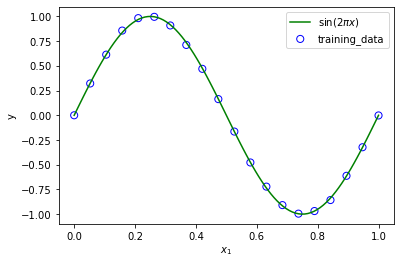

In [9]:
# Task: Try changing the std to different values and check the effect on data ---
# Try std from {0.001, 0.01, 0.1, 1, 10}

# std = 0.01
X,y = create_nonlin_training_set(nonlin_sin, sample_size=20, std=0.01)
visualize_training_data(X,y)

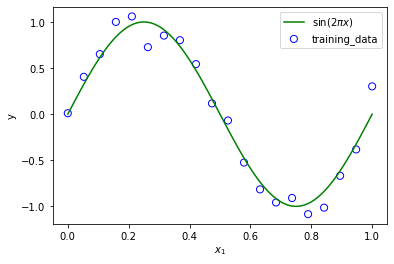

In [73]:
# std = 0.1
X,y = create_nonlin_training_set(nonlin_sin, sample_size=20, std=0.1)
visualize_training_data(X,y)

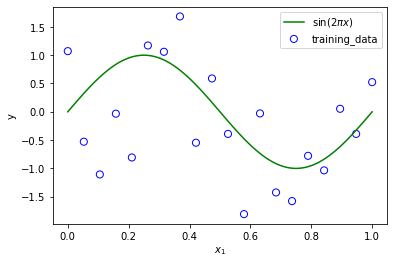

In [74]:
# std = 1
X,y = create_nonlin_training_set(nonlin_sin, sample_size=20, std=1)
visualize_training_data(X,y)

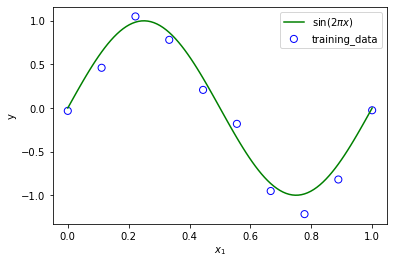

In [85]:
# We keep a std = 0.2 and no. of samples to 10, to depict overfitting
X,y = create_nonlin_training_set(nonlin_sin, sample_size=10, std=0.2)
visualize_training_data(X,y)

## Polynomial Model

Let's train a polynomial model on this data.

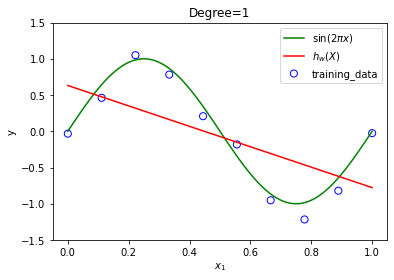

In [94]:
# # Task: Try changing degree to different values check the effect on data ---
# Try degree from {1, 3, 5, 7, 9}

degree = 1
X_transform = polynomial_transform(X, degree=degree)
lin_reg = LinReg()
lin_reg.fit(X_transform, y) # Uses the normal equation method
visualize_model_fit(X,y, linear_model=lin_reg, degree=degree)

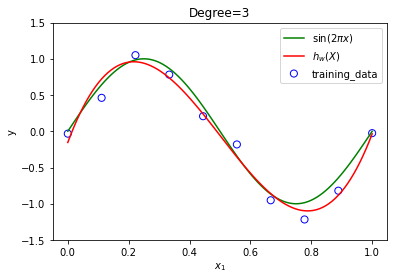

In [95]:
degree = 3
X_transform = polynomial_transform(X, degree=degree)
lin_reg = LinReg()
lin_reg.fit(X_transform, y) # Uses the normal equation method
visualize_model_fit(X,y, linear_model=lin_reg, degree=degree)

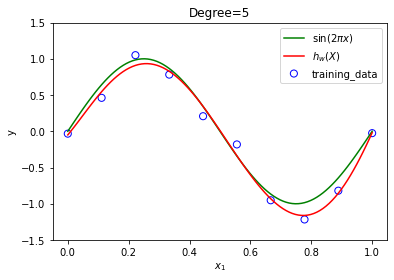

In [96]:
degree = 5
X_transform = polynomial_transform(X, degree=degree)
lin_reg = LinReg()
lin_reg.fit(X_transform, y) # Uses the normal equation method
visualize_model_fit(X,y, linear_model=lin_reg, degree=degree)

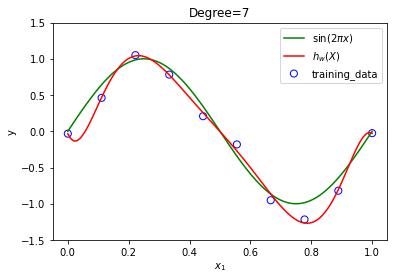

In [97]:
degree = 7
X_transform = polynomial_transform(X, degree=degree)
lin_reg = LinReg()
lin_reg.fit(X_transform, y) # Uses the normal equation method
visualize_model_fit(X,y, linear_model=lin_reg, degree=degree)

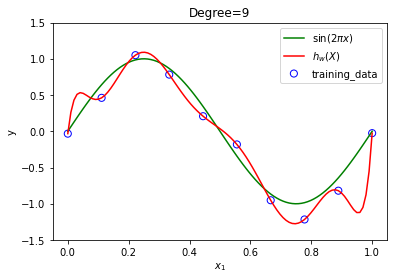

In [98]:
degree = 9
X_transform = polynomial_transform(X, degree=degree)
lin_reg = LinReg()
lin_reg.fit(X_transform, y) # Uses the normal equation method
visualize_model_fit(X,y, linear_model=lin_reg, degree=degree)

Looking at these together.

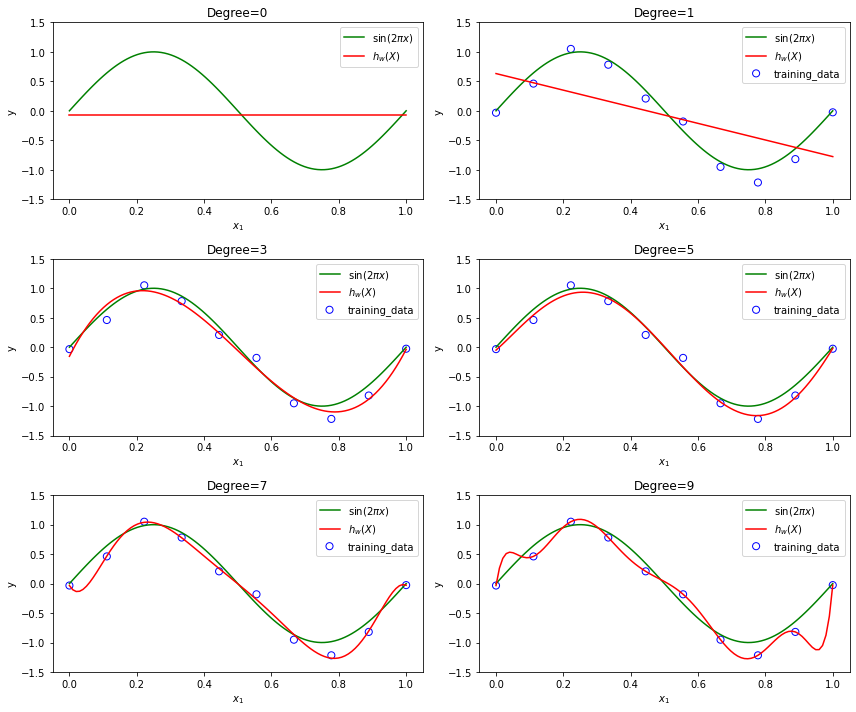

In [125]:
fig = plt.figure(figsize=(12,10))

for i, degree in enumerate([0,1,3,5,7,9]):
    plt.subplot(3,2, i+1)

    X_transform = polynomial_transform(X, degree=degree)

    lin_reg = LinReg()
    lin_reg.fit(X_transform,y)

    visualize_model_fit(X,y, linear_model=lin_reg, degree=degree)

fig.tight_layout()
plt.show()

## Model Selection

- One polynomial model per degree. Which one to select?
- Process
    - Fix the list of degrees that you want to experiment with.
    - Divide the training data into training, validation and test.
    - For each degree $m$:
        - Training polynomial regression model with training data.
        - Calculate training and validation errors on the trained model.
- Select the model with lowest training and validation loss amongst all the models.

**Model Selection Helper Functions**

To help us out we define a few helper functions.

In [7]:
import pandas as pd

def convert_dict_to_df(w_dict, highest_degree=1):
    '''
    This function will help us convert the dictionary storing various 
    weight vectors obtained from various degrees into a Pandas DataFrame.

    w_dict: This is the dictionary containing the combined weights of trained weight vector for each degree from 0 to highest_degree.
    highest_degree: This is the highest degree to be trained till starting from 0.
    '''
    # Initialize a a dictionary on 0's to be filled with the weight vectors.
    poly_w_dict = {i: np.array(np.zeros(highest_degree)) for i in range(highest_degree)}

    for deg in poly_w_dict:
        weight_vector = w_dict[deg]
        for i in range(len(weight_vector)):
            poly_w_dict[deg][i] = weight_vector[i]
            # Remaining unfilled elements of weight_vector[i] will keep being 0 by default.
    
    poly_w_df = pd.DataFrame(poly_w_dict)
    poly_w_df.columns = ['weights_degree_'+str(i) for i in range(highest_degree)]
    
    return poly_w_df

def plot_model_selection(training_errors, validation_errors):
        '''
        This function will draw the plots of RMSE error vs degree, post training, for both training and validation sets.
        
        This will help us determine which degree to choose to fit our model with. This is someting that is degree is going to be fu
        '''
        plt.figure(figsize=(12,6))
        plt.plot(training_errors, 'o-', mfc="none", mec='b', ms=10, c='b', label='training')
        plt.plot(validation_errors, 'o-', mfc="none", mec='r', ms=10, c='r', label='validation')
        plt.legend()
        plt.xlabel('degree')
        plt.ylabel('RMSE')
        plt.show()

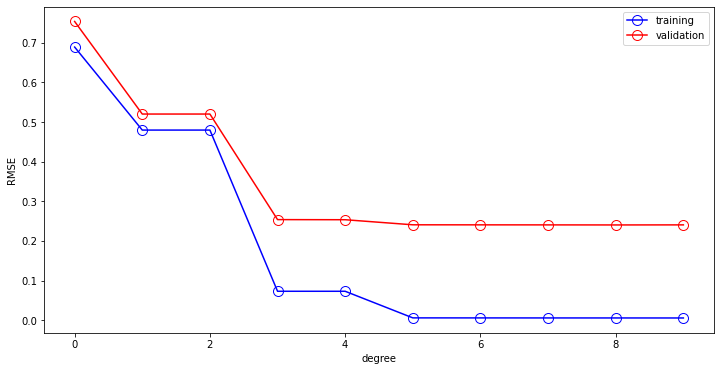

,weights_degree_0,weights_degree_1,weights_degree_2,weights_degree_3,weights_degree_4,weights_degree_5,weights_degree_6,weights_degree_7,weights_degree_8,weights_degree_9
0,-0.000354,0.814758,0.815912,-0.111841,-0.114768,-0.001969,-0.000842,0.000004,0.000424,0.000762
1,0.000000,-1.630225,-1.637531,11.163033,11.239147,6.029947,5.938427,5.814377,5.696342,5.495811
2,0.000000,0.000000,0.007306,-32.827869,-33.191055,6.980500,8.030294,10.025193,12.557611,18.036688
3,0.000000,0.000000,0.000000,21.890117,22.464262,-88.385941,-92.810931,-104.676901,-124.773367,-180.236731
4,0.000000,0.000000,0.000000,0.000000,-0.287073,125.816678,134.300277,167.989171,246.292026,527.569779
5,0.000000,0.000000,0.000000,0.000000,0.000000,-50.441500,-57.966825,-107.212062,-273.356644,-1077.939120
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.508442,38.278121,234.058042,1591.007630
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-10.219908,-130.561389,-1468.087290
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.085370,742.454884
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-158.304336


In [10]:
training_errors = []
validation_errors = []
w_dict = {}

# Creating our validation data
X_val = np.linspace(0,1,100)
y_val = nonlin_sin(X_val) + np.random.normal(scale=0.25, size=len(X_val))

# We want to check from degrees [0,9]
for i in range(10):
    X_transform = polynomial_transform(X, i)
    X_val_transform = polynomial_transform(X_val, i)
    
    lin_reg = LinReg()
    lin_reg.fit(X_transform, y)

    w_dict[i] = lin_reg.w
    training_errors.append(lin_reg.rmse(X_transform,y))
    validation_errors.append(lin_reg.rmse(X_val_transform, y_val))

plot_model_selection(training_errors=training_errors, validation_errors=validation_errors)

convert_dict_to_df(w_dict,10)

**Observations:**

- Higher order polynomial terms are assigned larger weights, The larger weights are problematic as a small change in the input causes a large change in the output.

E.g. ---

$y = 0.53 + 185 x_1 + 894 x_1^2 + 3250 x_1^3$ and change $x_1$ from $1$ to $2$ and the corresponding $y$ values are $h_w(x_1 = 1) = 4328.47$ and $h_w(x_1 = 2) = 29945.47$.

This is called *high variance problem* or *overfitting problem*.

- We can fix the overfitting problem with more data. Try running theh analysis with no. of samples = 10, 100, 1000 and observe the weight vectors for higher order polynomial models.

- Note down which polynomial model is suitable for different sample sizes.

In [11]:
# Creating our validation data.
X_val = np.linspace(0,1,100)
y_val_without_noise = nonlin_sin(X_val)
y_val = y_val_without_noise + np.random.normal(scale=0.25, size=len(X_val))

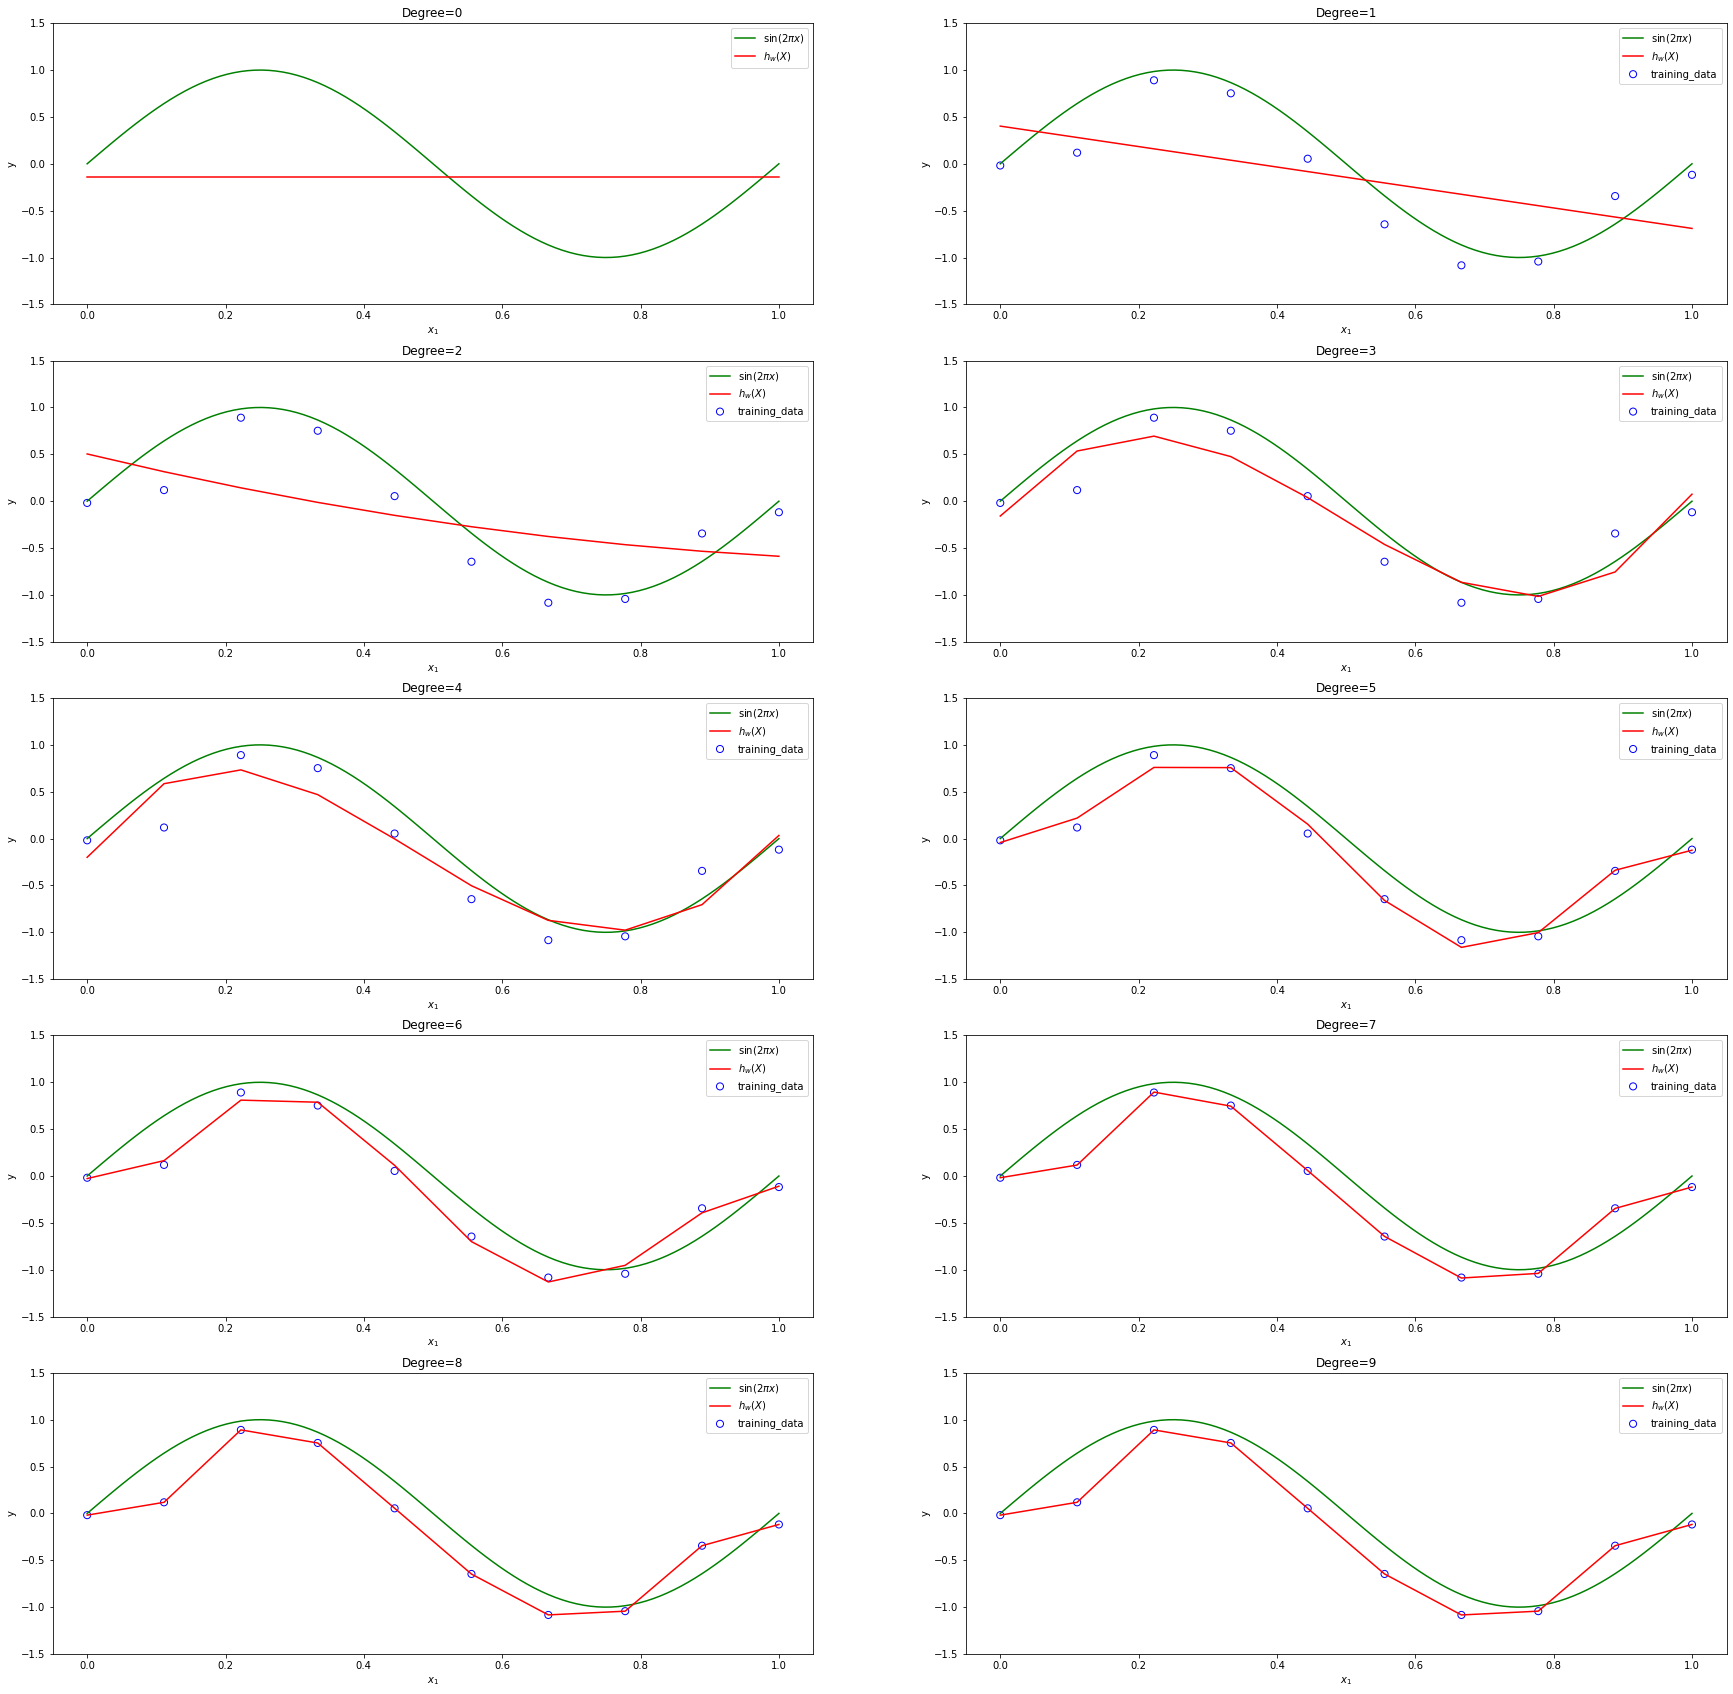

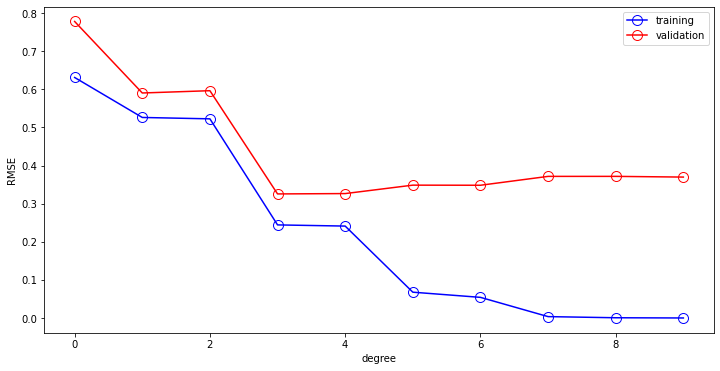

,weights_degree_0,weights_degree_1,weights_degree_2,weights_degree_3,weights_degree_4,weights_degree_5,weights_degree_6,weights_degree_7,weights_degree_8,weights_degree_9
0,-0.14378,0.401973,0.503991,-0.158251,-0.199450,-0.042240,-0.027228,-0.018235,-0.018443,-0.018452
1,0.00000,-1.091506,-1.780129,9.123218,10.668189,-3.653651,-7.659632,-17.384400,-15.895290,-15.027727
2,0.00000,0.000000,0.688623,-28.047964,-35.850069,83.531349,132.954211,293.420494,263.390463,243.351263
3,0.00000,0.000000,0.000000,19.157725,31.671992,-305.779484,-518.500115,-1470.083507,-1243.579604,-1063.079159
4,0.00000,0.000000,0.000000,0.000000,-6.257133,380.538662,791.616152,3482.276259,2627.802799,1779.835775
5,0.00000,0.000000,0.000000,0.000000,0.000000,-154.718318,-520.378927,-4444.145576,-2665.213955,-355.036814
6,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,121.886870,2969.389476,893.969251,-2888.805917
7,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-813.572173,457.093271,4126.150228
8,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-317.666361,-2258.864400
9,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,431.377342


In [12]:
# Start plot
plt.figure(figsize=(30,30))

# Generating data with 10 samples.
X,y = create_nonlin_training_set(nonlin_sin, 10, std=0.2)

training_errors = []
validation_errors = []
w_dict = {}

# We want to check from degrees [0,9]
for i in range(10):
    X_transform = polynomial_transform(X, i)
    X_val_transform = polynomial_transform(X_val, i)
    
    lin_reg = LinReg()
    lin_reg.fit(X_transform, y)

    w_dict[i] = lin_reg.w
    training_errors.append(lin_reg.rmse(X_transform,y))
    validation_errors.append(lin_reg.rmse(X_val_transform, y_val))

    plt.subplot(5,2, i+1)
    
    # plotting function
    plt.plot(X_val, y_val_without_noise, c='g', label='$\sin(2\pi x)$')
    
    # plotting the scatterplot of X vs y
    if i > 0:
        plt.scatter(X,y, facecolor="none", edgecolor='b', s =50, label='training_data')
    
    # plotting the trained model
    y_hat = lin_reg.predict(X_transform)

    plt.plot(X, y_hat, c='r', label='$h_w(X)$')
    plt.xlabel('$x_1$')
    plt.ylabel('y')
    plt.ylim(-1.5,1.5)
    plt.title("Degree={}".format(i))
    plt.legend()
    


plot_model_selection(training_errors=training_errors, validation_errors=validation_errors)

convert_dict_to_df(w_dict,10)

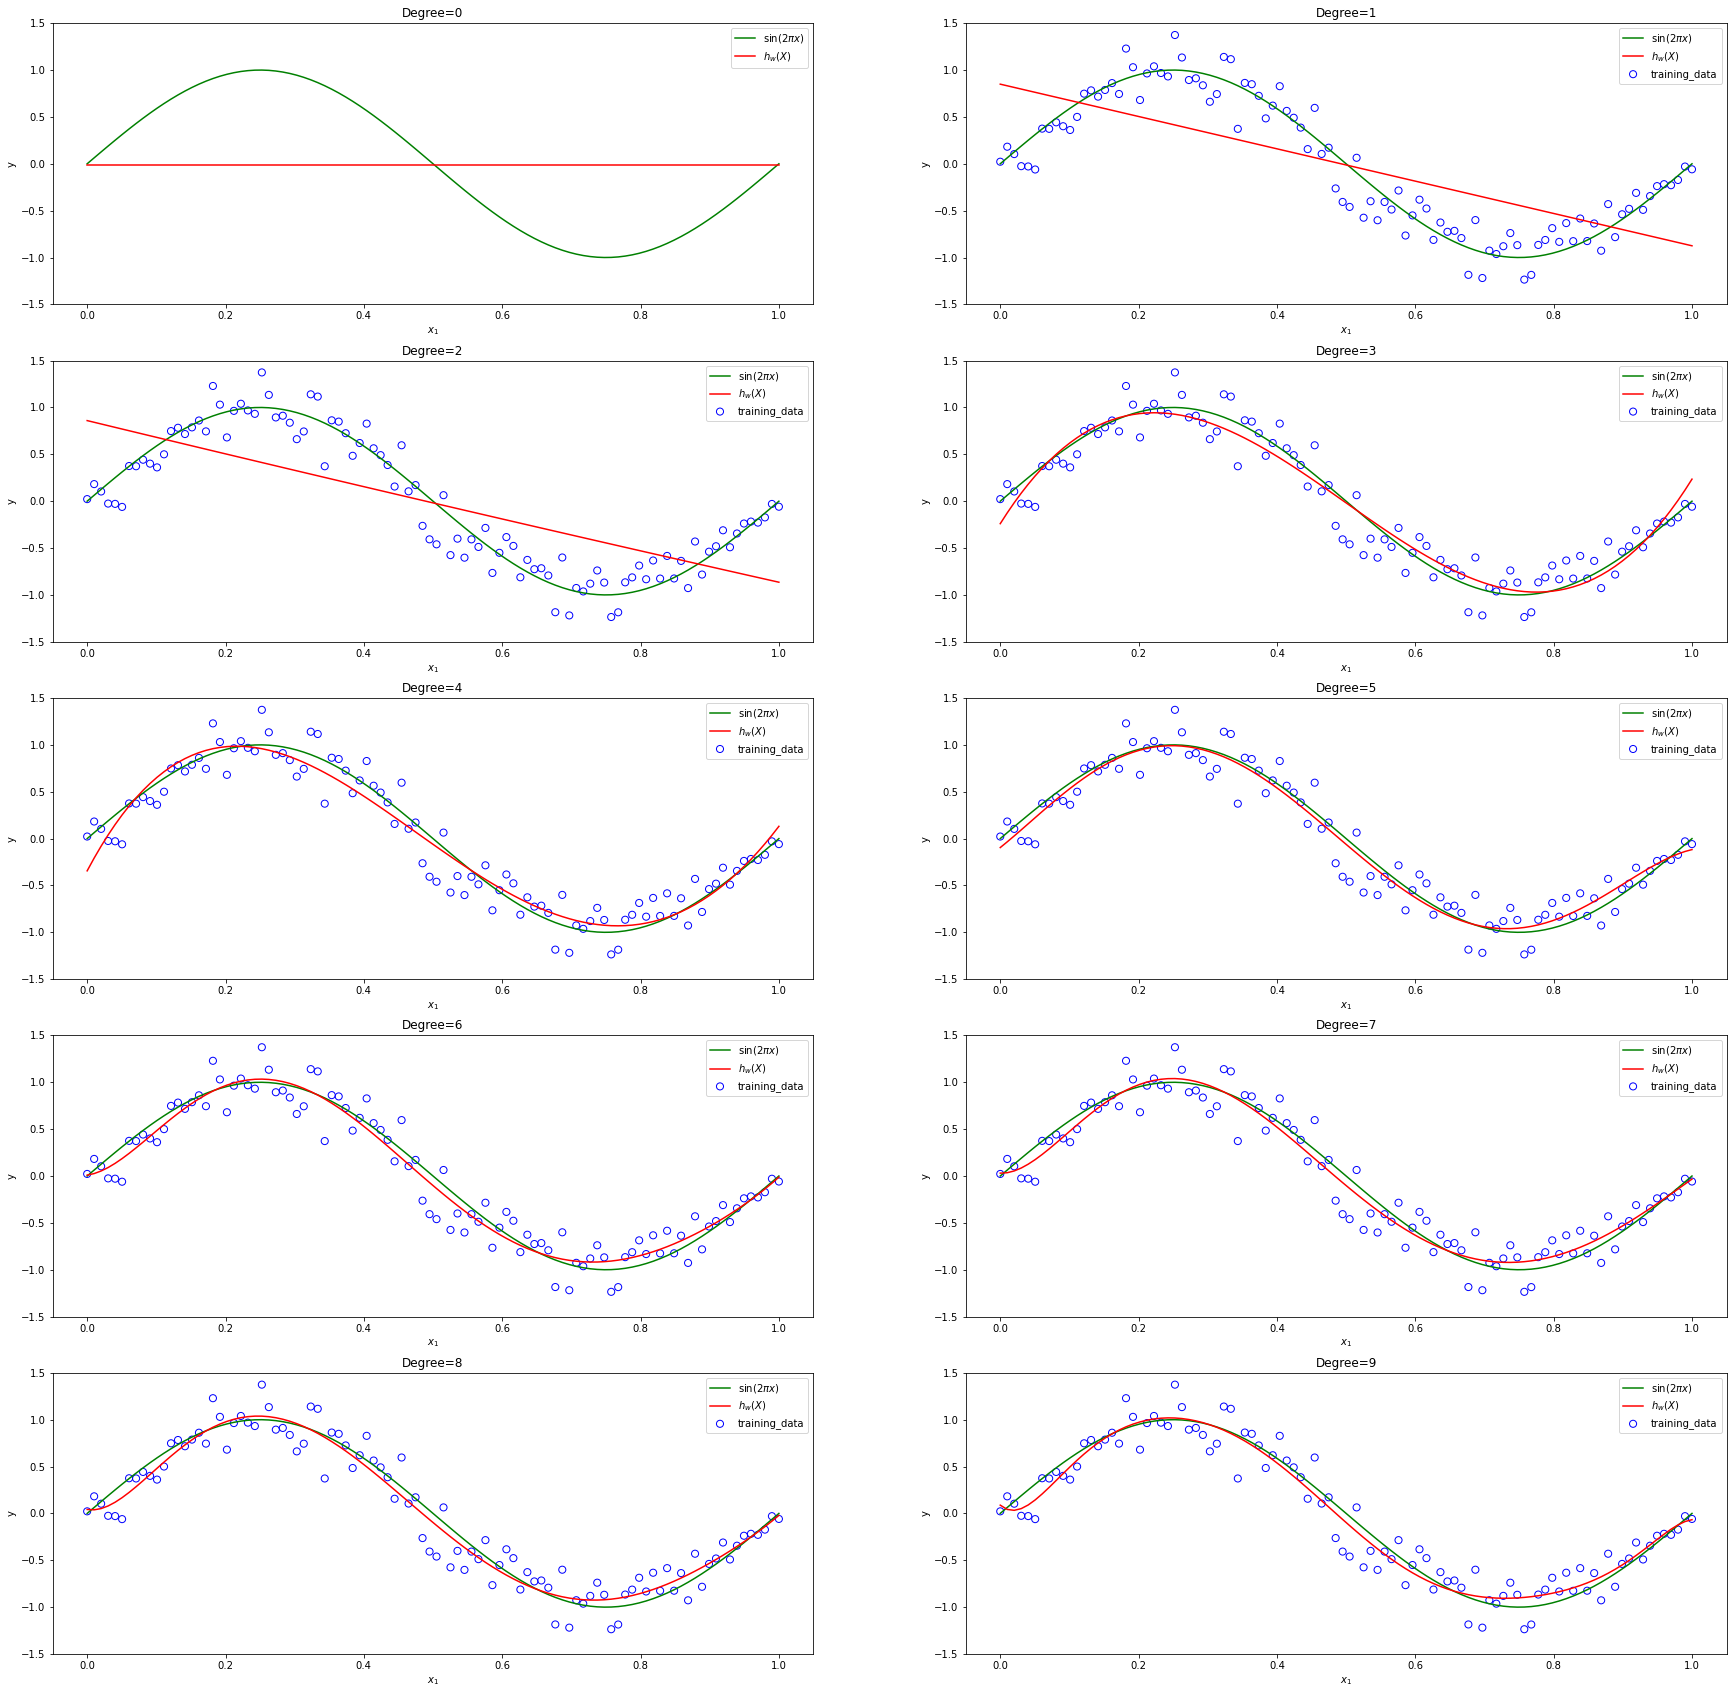

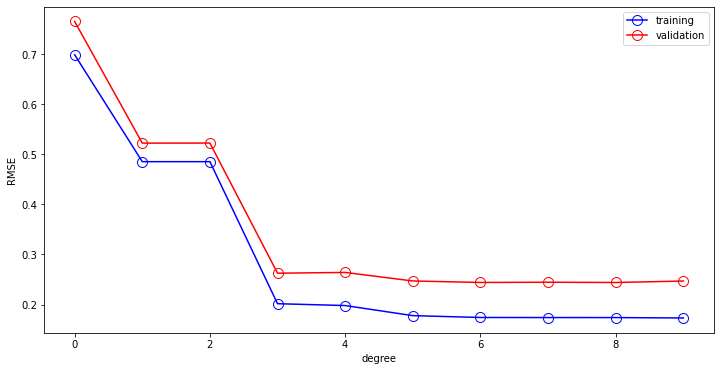

,weights_degree_0,weights_degree_1,weights_degree_2,weights_degree_3,weights_degree_4,weights_degree_5,weights_degree_6,weights_degree_7,weights_degree_8,weights_degree_9
0,-0.012702,0.849534,0.859979,-0.239851,-0.344007,-0.095599,0.009615,0.030377,0.042192,0.088173
1,0.000000,-1.724474,-1.787778,11.751482,13.933387,5.918525,1.009145,-0.333701,-1.362206,-6.639025
2,0.000000,0.000000,0.063304,-33.955500,-43.889553,13.345022,63.921115,82.808333,101.798738,225.992926
3,0.000000,0.000000,0.000000,22.679203,38.183498,-115.574341,-320.357410,-427.150880,-569.742482,-1764.318852
4,0.000000,0.000000,0.000000,0.000000,-7.752147,165.650036,551.665674,847.871031,1389.104953,7306.137857
5,0.000000,0.000000,0.000000,0.000000,0.000000,-69.360873,-409.709798,-837.996678,-1971.074542,-18688.750769
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,113.449642,423.254379,1749.533866,29755.385574
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-88.515639,-901.590095,-28410.388645
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,203.268614,14833.613589
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3251.187772


In [13]:
# Start plot
plt.figure(figsize=(30,30))

# Generating data with 100 samples.
X,y = create_nonlin_training_set(nonlin_sin, 100, std=0.2)

training_errors = []
validation_errors = []
w_dict = {}

# We want to check from degrees [0,9]
for i in range(10):
    X_transform = polynomial_transform(X, i)
    X_val_transform = polynomial_transform(X_val, i)
    
    lin_reg = LinReg()
    lin_reg.fit(X_transform, y)

    w_dict[i] = lin_reg.w
    training_errors.append(lin_reg.rmse(X_transform,y))
    validation_errors.append(lin_reg.rmse(X_val_transform, y_val))

    plt.subplot(5,2, i+1)
    
    # plotting function
    plt.plot(X_val, y_val_without_noise, c='g', label='$\sin(2\pi x)$')
    
    # plotting the scatterplot of X vs y
    if i > 0:
        plt.scatter(X,y, facecolor="none", edgecolor='b', s =50, label='training_data')
    
    # plotting the trained model
    y_hat = lin_reg.predict(X_transform)

    plt.plot(X, y_hat, c='r', label='$h_w(X)$')
    plt.xlabel('$x_1$')
    plt.ylabel('y')
    plt.ylim(-1.5,1.5)
    plt.title("Degree={}".format(i))
    plt.legend()
    


plot_model_selection(training_errors=training_errors, validation_errors=validation_errors)

convert_dict_to_df(w_dict,10)

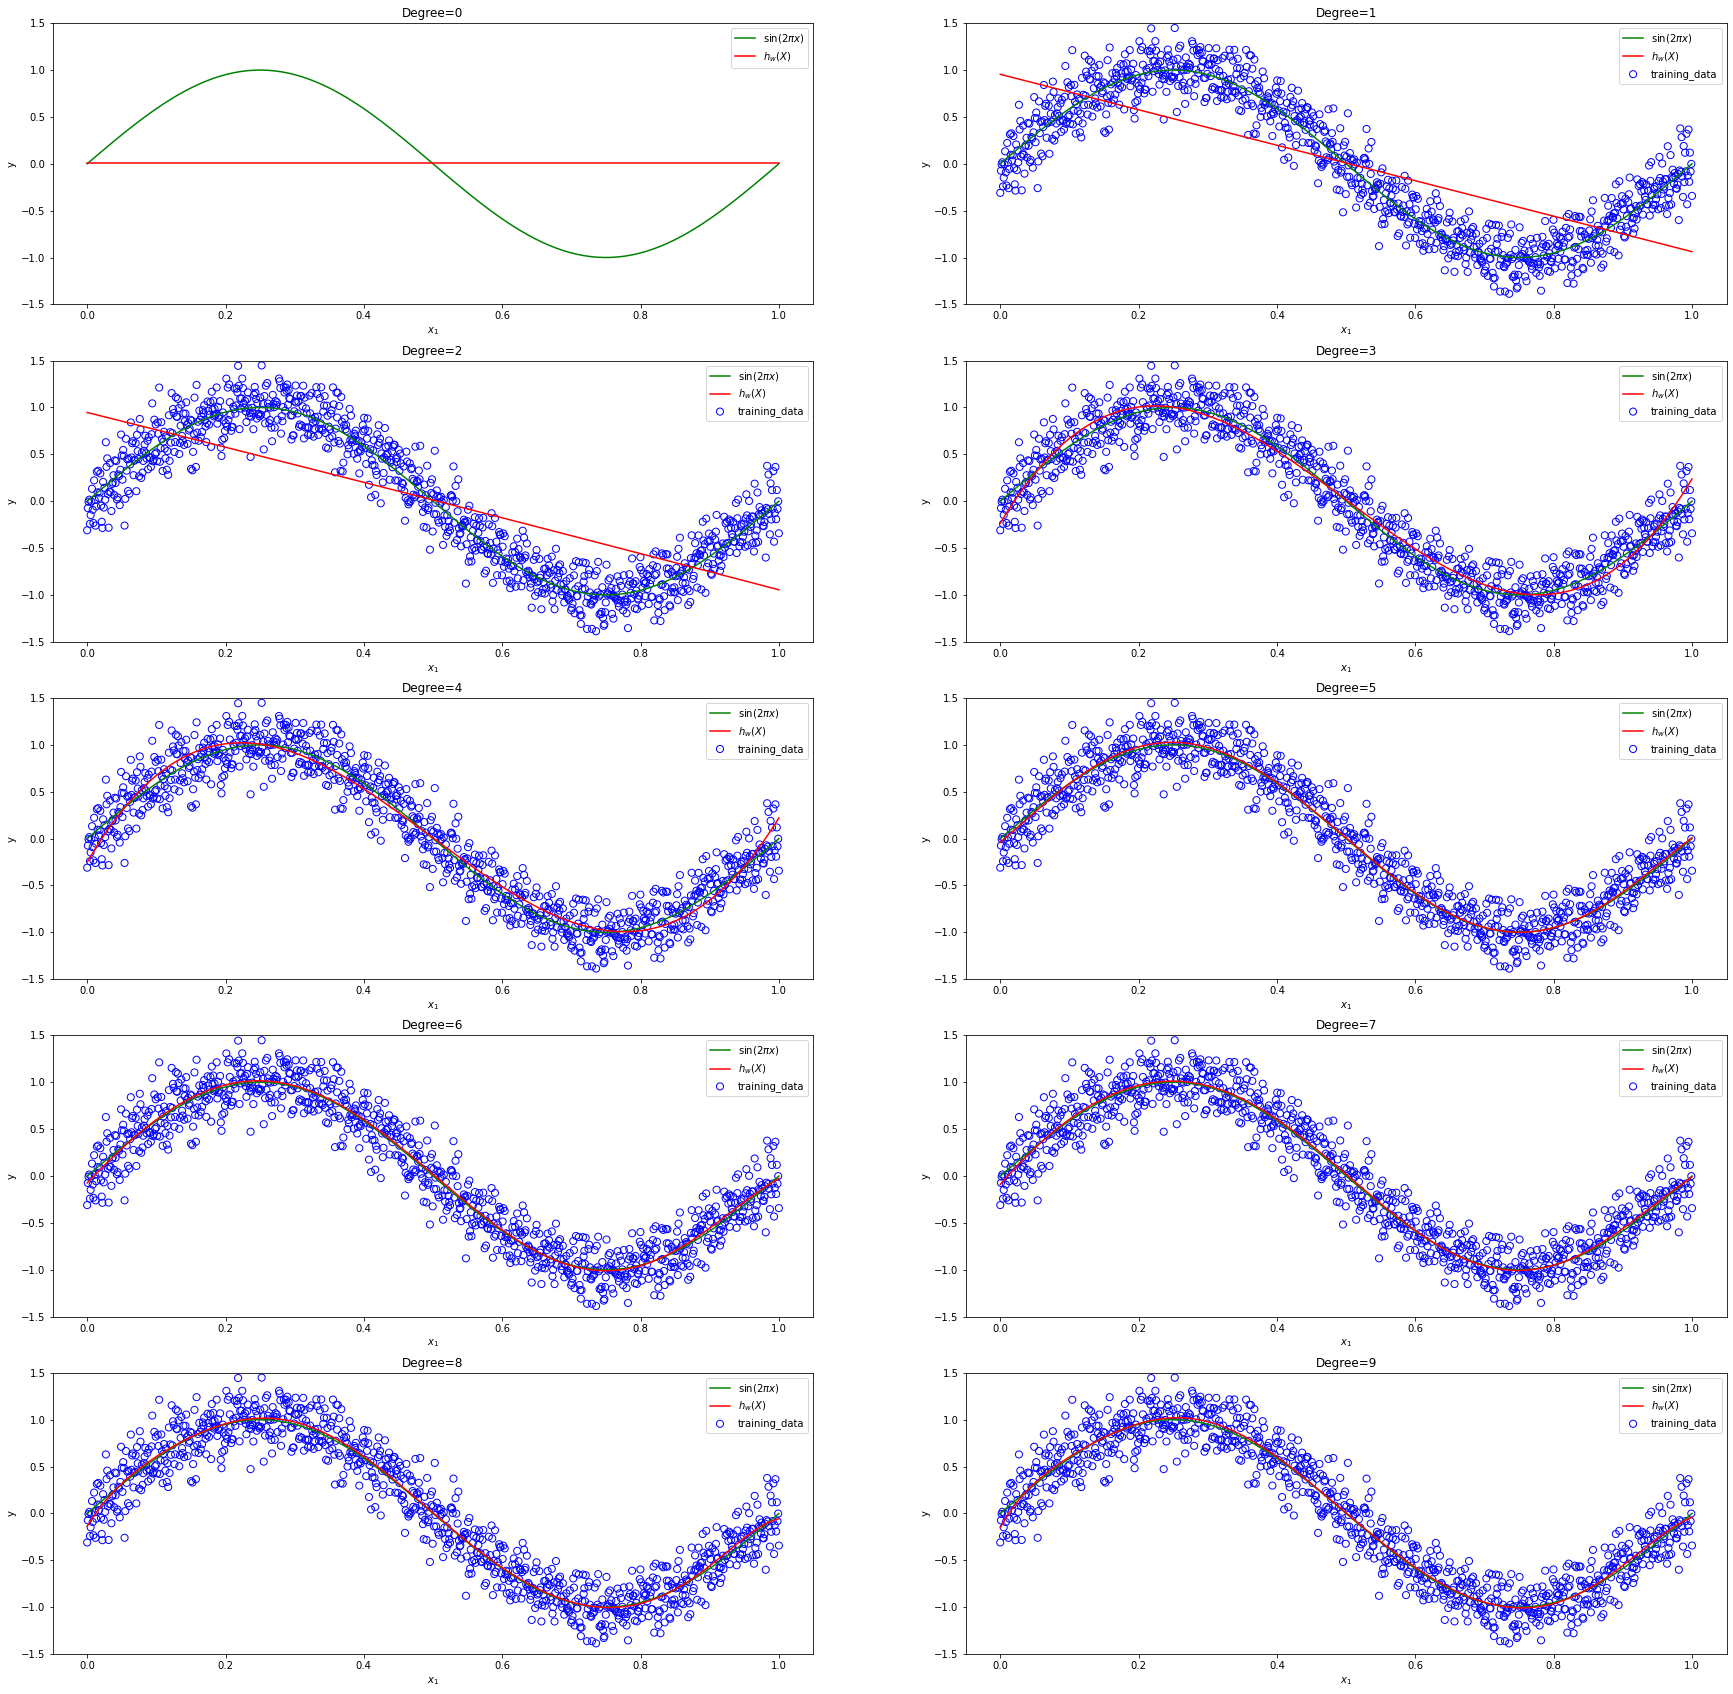

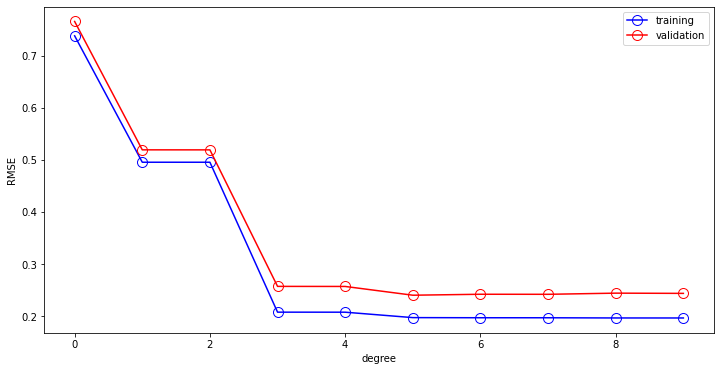

,weights_degree_0,weights_degree_1,weights_degree_2,weights_degree_3,weights_degree_4,weights_degree_5,weights_degree_6,weights_degree_7,weights_degree_8,weights_degree_9
0,0.0086,0.954749,0.946721,-0.235766,-0.251332,-0.039275,-0.074359,-0.090126,-0.137257,-0.152376
1,0.0000,-1.892298,-1.844083,12.381349,12.694084,6.287513,7.775940,8.670950,12.124747,13.516044
2,0.0000,0.000000,-0.048215,-35.629590,-37.038542,7.897218,-7.031733,-19.164753,-79.938887,-110.761835
3,0.0000,0.000000,0.000000,23.720917,25.913349,-94.005124,-34.214811,33.314094,480.100966,768.712021
4,0.0000,0.000000,0.000000,0.000000,-1.096216,133.845734,21.677419,-164.193484,-1841.809542,-3251.231805
5,0.0000,0.000000,0.000000,0.000000,0.000000,-53.976780,44.751011,312.520504,3804.387592,7754.680774
6,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,-32.909264,-226.330396,-4301.619328,-10889.166650
7,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.263181,2550.691669,9005.738111
8,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-623.857122,-4053.524671
9,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,762.148344


In [14]:
# Start plot
plt.figure(figsize=(30,30))

# Generating data with 1000 samples.
X,y = create_nonlin_training_set(nonlin_sin, 1000, std=0.2)

training_errors = []
validation_errors = []
w_dict = {}

# We want to check from degrees [0,9]
for i in range(10):
    X_transform = polynomial_transform(X, i)
    X_val_transform = polynomial_transform(X_val, i)
    
    lin_reg = LinReg()
    lin_reg.fit(X_transform, y)

    w_dict[i] = lin_reg.w
    training_errors.append(lin_reg.rmse(X_transform,y))
    validation_errors.append(lin_reg.rmse(X_val_transform, y_val))

    plt.subplot(5,2, i+1)
    
    # plotting function
    plt.plot(X_val, y_val_without_noise, c='g', label='$\sin(2\pi x)$')
    
    # plotting the scatterplot of X vs y
    if i > 0:
        plt.scatter(X,y, facecolor="none", edgecolor='b', s =50, label='training_data')
    
    # plotting the trained model
    y_hat = lin_reg.predict(X_transform)

    plt.plot(X, y_hat, c='r', label='$h_w(X)$')
    plt.xlabel('$x_1$')
    plt.ylabel('y')
    plt.ylim(-1.5,1.5)
    plt.title("Degree={}".format(i))
    plt.legend()
    


plot_model_selection(training_errors=training_errors, validation_errors=validation_errors)

convert_dict_to_df(w_dict,10)

As we can easily observe, increasing the no. of training examples greatly helps reduce overfitting by lowering the weights of the higher degree polynomials.